In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import scipy.stats
from math import sqrt

In [55]:
cdata = pd.read_csv("london_flows.csv")

In [56]:
cdata = cdata[cdata["station_origin"] != cdata["station_destination"]]

In [57]:
cdata = cdata[cdata["flows"] != 0]

In [58]:
cdata

,station_origin,station_destination,flows,population,jobs,distance
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167
5,Abbey Road,Crossharbour,1,599,1208,6686.475560
...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554


In [59]:
def CalcRSquared(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

#### Select a spatial interaction model to simulate the flows

In [60]:
#take the variables and produce logarithms of them
x_variables = ["population", "jobs", "distance"]
log_x_vars = []
for x in x_variables:
    cdata[f"log_{x}"] = np.log(cdata[x])
    log_x_vars.append(f"log_{x}")

In [61]:
cdata

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,6.395262,7.096721,8.807842
...,...,...,...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.973605,8.114325,9.503144
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8.973605,8.610137,9.071245
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,8.973605,5.991465,9.162905
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.973605,6.794587,8.585832


In [62]:
#create the formula
formula = 'flows ~ log_population + log_jobs + log_distance'

#run the regression
uncosim = smf.glm(formula = formula,
                  data=cdata,
                  family=sm.families.Poisson()).fit()

In [63]:
#extract the summary of the constrained model
print(uncosim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                43945
Model:                            GLM   Df Residuals:                    43941
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1675e+06
Date:                Tue, 17 May 2022   Deviance:                   2.1627e+06
Time:                        06:59:43   Pearson chi2:                 4.13e+06
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -3.0646      0.014   -223.

In [64]:
#first assign the parameter values from the model to the appropriate variables
k1 = uncosim.params[0]
alpha1 = uncosim.params[1]
gamma1 = uncosim.params[2]
beta1 = -uncosim.params[3]

#now plug everything back into the Equation 6 model ... 
#be careful with the negative signing of the parameter beta
cdata["unconstrainedEst1"] = np.exp(k1 
                                       + alpha1*cdata["log_population"] 
                                       + gamma1*cdata["log_jobs"] 
                                       - beta1*cdata["log_distance"])

In [65]:
beta1

0.5961473054763105

In [103]:
alpha1

0.697278458257221

In [104]:
gamma1

0.703702826370599

In [66]:
#round the numbers so that we don't get a half of a person
cdata["unconstrainedEst1"] = round(cdata["unconstrainedEst1"], 0)
#convert to integers
cdata["unconstrainedEst1"] = cdata["unconstrainedEst1"].astype(int)
#check that the sum of these estimates make sense
sum(cdata["unconstrainedEst1"])

1542307

In [67]:
CalcRSquared(cdata["flows"], cdata["unconstrainedEst1"])

0.3114155959170229

In [68]:
CalcRMSE(cdata["flows"], cdata["unconstrainedEst1"])

128.175

#### Scenario A

In [69]:
cdata2 = cdata.copy()

In [70]:
#create the formula (the "-1" indicates no intercept in the regression model).
formula = 'flows ~ station_origin + log_jobs + log_distance-1'
#run a production constrained sim
prodSim = smf.glm(formula = formula, data=cdata2, family=sm.families.Poisson()).fit()
#let's have a look at it's summary

In [71]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
#to create O_i, take cdatasub ...then... group by origcodenew ...then... summarise by calculating the sum of Total
O_i = pd.DataFrame(cdata2.groupby(["station_origin"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
cdata2 = cdata2.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(cdata2.groupby(["station_destination"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
cdata2 = cdata2.merge(D_j, on = "station_destination", how = "left" )

In [72]:
#We can do this by pulling out the parameter values
coefs = pd.DataFrame(prodSim.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")

/tmp/ipykernel_1106/2784153587.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs["coef"] = coefs["coef"].str.replace(x, "")


In [73]:
coefs["coef"] = coefs["coef"].str.replace("Intercept","Abbey Road")

In [74]:
coefs

,coef,alpha_i
0,Abbey Road,3.270351
1,Acton Central,5.008886
2,Acton Town,4.397394
3,Aldgate,3.361125
4,Aldgate East,3.408728
...,...,...
395,Woodgrange Park,5.320215
396,Woodside Park,4.496709
397,Woolwich Arsenal,6.701868
398,log_jobs,0.730170


In [75]:
#then once you have done this you can join them back into the dataframes
cdata2 = cdata2.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
cdata2.drop(columns = ["coef"], inplace = True)
#check this has worked
cdata2.head(5)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,unconstrainedEst1,O_i,D_j,alpha_i
0,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,1,599,442,3.270351
1,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,3,599,665,3.270351
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,57,599,58772,3.270351
3,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,36,599,15428,3.270351
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,6.395262,7.096721,8.807842,3,599,1208,3.270351


In [76]:
alpha_i = prodSim.params[0:-2]
gamma = prodSim.params[-2]
beta = -prodSim.params[-1]

In [102]:
alpha_i

station_origin[Abbey Road]          3.270351
station_origin[Acton Central]       5.008886
station_origin[Acton Town]          4.397394
station_origin[Aldgate]             3.361125
station_origin[Aldgate East]        3.408728
                                      ...   
station_origin[Wood Street]         5.672160
station_origin[Woodford]            4.955425
station_origin[Woodgrange Park]     5.320215
station_origin[Woodside Park]       4.496709
station_origin[Woolwich Arsenal]    6.701868
Length: 398, dtype: float64

In [77]:
gamma

0.7301699265793905

In [78]:
beta

0.8151874614788015

In [79]:
cdata2["prodsimest1"] = np.exp(cdata2["alpha_i"]+gamma*cdata2["log_jobs"] 
                                 - beta*cdata2["log_distance"])
#or you could do it the easy way like we did last week with the fitted column (See previous practical)
cdata2.head(5)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,unconstrainedEst1,O_i,D_j,alpha_i,prodsimest1
0,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,1,599,442,3.270351,1.406918
1,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,3,599,665,3.270351,3.677350
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,57,599,58772,3.270351,76.062924
3,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,36,599,15428,3.270351,56.123931
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,6.395262,7.096721,8.807842,3,599,1208,3.270351,3.568414


In [80]:
CalcRSquared(cdata2["flows"], cdata2["prodsimest1"])

0.3937304850830752

In [81]:
def new_jobs(row):
    if row["station_destination"] == "Canary Wharf":
        val = row["jobs"]/2
    else:
        val = row["jobs"]
    return val
        
cdata2["jobScenario"] = cdata2.apply(new_jobs, axis =1)
cdata2.head(10)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,unconstrainedEst1,O_i,D_j,alpha_i,prodsimest1,jobScenario
0,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,1,599,442,3.270351,1.406918,442.0
1,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,3,599,665,3.270351,3.677350,665.0
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,57,599,58772,3.270351,76.062924,29386.0
3,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,36,599,15428,3.270351,56.123931,15428.0
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,6.395262,7.096721,8.807842,3,599,1208,3.270351,3.568414,1208.0
5,Abbey Road,Cutty Sark,2,599,1748,8503.898909,6.395262,7.466228,9.048280,4,599,1748,3.270351,3.841726,1748.0
6,Abbey Road,Cyprus,7,599,850,6532.099618,6.395262,6.745236,8.784484,2,599,850,3.270351,2.813752,850.0
7,Abbey Road,Devons Road,1,599,611,3958.324171,6.395262,6.415097,8.283576,3,599,611,3.270351,3.326081,611.0
8,Abbey Road,East India,2,599,1522,3384.141666,6.395262,7.327781,8.126856,6,599,1522,3.270351,7.359304,1522.0
9,Abbey Road,Island Gardens,2,599,691,7706.296370,6.395262,6.538140,8.949793,2,599,691,3.270351,2.113923,691.0


In [82]:
cdata2["prodsimest2"] = np.exp(cdata2["alpha_i"]+gamma*np.log(cdata2["jobScenario"]) - beta*cdata2["log_distance"])

cdata2["prodsimest2"] = round(cdata2["prodsimest2"],0)

In [83]:
#calculate some new wj^alpha and d_ij^beta values
Dj2_gamma = cdata2["jobs"]**gamma
dist_beta = cdata2["distance"]**beta
#calcualte the first stage of the Ai values
cdata2["Ai1"] = Dj2_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(cdata2.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i"}, inplace=True)
#and write the A_i values back into the dataframe
cdata2 = cdata2.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [84]:
#to check everything works, recreate the original estimates
cdata2["prodsimest3"] = cdata2["A_i"]*cdata2["O_i"]*Dj2_gamma*dist_beta
#round
cdata2["prodsimest3"] = round(cdata2["prodsimest3"])

In [85]:
#calculate some new wj^alpha and d_ij^beta values
Dj3_gamma = cdata2["jobScenario"]**gamma
#calcualte the first stage of the Ai values
cdata2["Ai1"] = Dj3_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(cdata2.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i2"}, inplace=True)
#and write the A_i values back into the dataframe
cdata2 = cdata2.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [86]:
#to check everything works, recreate the original estimates
cdata2["prodsimest4"] = cdata2["A_i2"]*cdata2["O_i"]*Dj3_gamma*dist_beta
#round
cdata2["prodsimest4"] = round(cdata2["prodsimest4"])

In [87]:
cdata2["change"] = cdata2["prodsimest4"]-cdata2["prodsimest3"]

In [88]:
cdata2.head(5)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,unconstrainedEst1,...,alpha_i,prodsimest1,jobScenario,prodsimest2,Ai1,A_i,prodsimest3,A_i2,prodsimest4,change
0,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,1,...,3.270351,1.406918,442.0,1.0,1.365344e+05,9.456490e-08,8.0,1.074350e-07,9.0,1.0
1,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,3,...,3.270351,3.677350,665.0,4.0,9.485046e+04,9.456490e-08,5.0,1.074350e-07,6.0,1.0
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,57,...,3.270351,76.062924,29386.0,46.0,1.922778e+06,9.456490e-08,181.0,1.074350e-07,124.0,-57.0
3,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,36,...,3.270351,56.123931,15428.0,56.0,6.130599e+05,9.456490e-08,35.0,1.074350e-07,39.0,4.0
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,6.395262,7.096721,8.807842,3,...,3.270351,3.568414,1208.0,4.0,2.337144e+05,9.456490e-08,13.0,1.074350e-07,15.0,2.0


<AxesSubplot:>

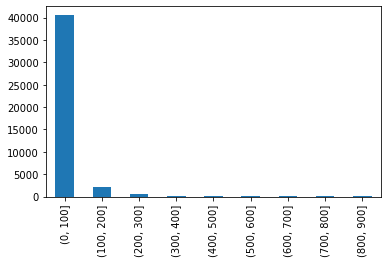

In [89]:
fig, ax = plt.subplots(figsize=(6, 3.5))
(
    pd.cut(cdata2['prodsimest4'], bins=np.arange(0, 1000, 100))
        .value_counts()
        .sort_index()
        .plot.bar(ax=ax)
)

In [90]:
cdata3 = cdata2.copy()

In [91]:
#create the formula (the "-1" indicates no intercept in the regression model).
dbl_form = 'flows ~ station_origin + station_destination + log_distance -1'
#run a doubly constrained sim
doubSim = smf.glm(formula = dbl_form, data=cdata3, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(doubSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                43945
Model:                            GLM   Df Residuals:                    43149
Model Family:                 Poisson   Df Model:                          795
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -8.6312e+05
Date:                Tue, 17 May 2022   Deviance:                   1.5540e+06
Time:                        07:03:00   Pearson chi2:                 2.10e+06
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [92]:
#get the estimates
cdata3["doubsimfitted"] = np.round(doubSim.mu)

In [93]:
CalcRSquared(cdata3["flows"],cdata3["doubsimfitted"])

0.4189377276057333

In [94]:
CalcRMSE(cdata3["flows"],cdata3["doubsimfitted"])

117.622

In [105]:
beta2 = -doubSim.params[-1]

In [106]:
beta2

0.847360200571664

In [95]:
doubsim_form = 'flows ~ station_origin + station_destination + distance-1'
doubsim1 = smf.glm(formula=doubsim_form, data = cdata3, family = sm.families.Poisson()).fit()
print(doubsim1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                43945
Model:                            GLM   Df Residuals:                    43149
Model Family:                 Poisson   Df Model:                          795
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -7.6208e+05
Date:                Tue, 17 May 2022   Deviance:                   1.3520e+06
Time:                        07:05:00   Pearson chi2:                 1.74e+06
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [96]:
cdata3["doubsimfitted1"] = np.round(doubsim1.mu,0)

In [97]:
CalcRSquared(cdata3["flows"],cdata3["doubsimfitted1"])

0.49977786985381284

In [98]:
CalcRMSE(cdata3["flows"],cdata3["doubsimfitted1"])

109.598

In [99]:
cdata3

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,unconstrainedEst1,...,jobScenario,prodsimest2,Ai1,A_i,prodsimest3,A_i2,prodsimest4,change,doubsimfitted,doubsimfitted1
0,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,1,...,442.0,1.0,1.365344e+05,9.456490e-08,8.0,1.074350e-07,9.0,1.0,3.0,4.0
1,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,3,...,665.0,4.0,9.485046e+04,9.456490e-08,5.0,1.074350e-07,6.0,1.0,3.0,4.0
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,57,...,29386.0,46.0,1.922778e+06,9.456490e-08,181.0,1.074350e-07,124.0,-57.0,84.0,127.0
3,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,36,...,15428.0,56.0,6.130599e+05,9.456490e-08,35.0,1.074350e-07,39.0,4.0,49.0,54.0
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,6.395262,7.096721,8.807842,3,...,1208.0,4.0,2.337144e+05,9.456490e-08,13.0,1.074350e-07,15.0,2.0,4.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43940,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.973605,8.114325,9.503144,25,...,3342.0,132.0,8.660342e+05,2.957584e-08,202.0,3.160778e-08,216.0,14.0,249.0,183.0
43941,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8.973605,8.610137,9.071245,47,...,5487.0,269.0,8.746933e+05,2.957584e-08,204.0,3.160778e-08,218.0,14.0,191.0,214.0
43942,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,8.973605,5.991465,9.162905,7,...,400.0,37.0,1.392843e+05,2.957584e-08,33.0,3.160778e-08,35.0,2.0,20.0,27.0
43943,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.973605,6.794587,8.585832,17,...,893.0,106.0,1.564146e+05,2.957584e-08,37.0,3.160778e-08,39.0,2.0,116.0,132.0


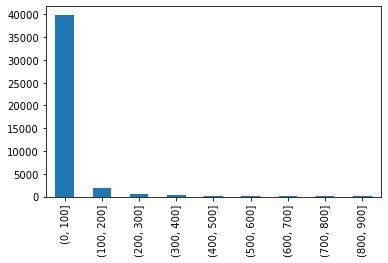

In [108]:
fig, ax = plt.subplots(figsize=(6, 3.5))
(
    pd.cut(cdata3['doubsimfitted1'], bins=np.arange(0, 1000, 100))
        .value_counts()
        .sort_index()
        .plot.bar(ax=ax)
)
plt.savefig("fig2.png")

In [110]:
cdata3["change1"] = cdata3["prodsimest4"] - cdata3["prodsimest2"]

In [111]:
cdata3["change2"] = cdata3["doubsimfitted1"] - cdata3["doubsimfitted"]

/tmp/ipykernel_1106/864212956.py:4: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f3123086e80>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(handles=[ln1,ln2],labels=['Scenario A','Scenario B'])
/tmp/ipykernel_1106/864212956.py:4: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f3123094280>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(handles=[ln1,ln2],labels=['Scenario A','Scenario B'])


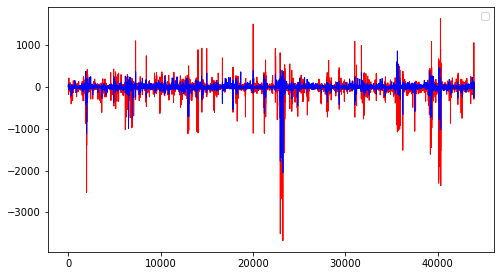

In [119]:
fig, ax = plt.subplots(figsize=(8, 4.5))
ln1=plt.plot(cdata3["change1"],color="red",linewidth=1.0,)
ln2=plt.plot(cdata3["change2"],color="blue",linewidth=1.0,)
plt.legend(handles=[ln1,ln2],labels=['Scenario A','Scenario B'])
# plt.savefig("change1.png")